# Statistical Distributions and their common use

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import pymc3 as pm
import seaborn as sns

## Continuous

### Normal


***e.g. normal distribution***

<div style="font-size: 150%;">  
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
</div>

* $X \in \mathbf{R}$
* $\mu \in \mathbf{R}$
* $\sigma>0$

$$\begin{align}E(X) &= \mu \cr
\text{Var}(X) &= \sigma^2 \end{align}$$

Since the means are real-valued, we will apply normal priors. Since we know something about the population distribution of IQ values, we will center the priors at 100, and use a standard deviation that is more than wide enough to account for plausible deviations from this population mean:


$$\mu_k \sim N(100, 10^2)$$

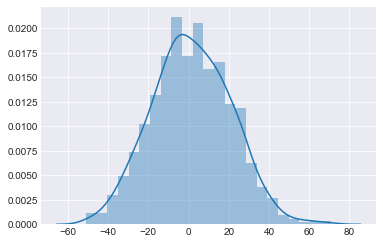

In [19]:
with pm.Model() as model:
    Normal = pm.Normal(mu = 3,sd = 20, name = "Normal_var")

samples = Normal.random(size=1000)  # Draw samples from the distribution
ax1 = sns.distplot(samples)

## Discrete

**Probability Mass Function**: 

For discrete $X$,

$$Pr(X=x) = f(x|\theta)$$



### Poisson

The Poisson distribution models unbounded counts. 

Examples: 
Number of messages obtained in a day


**Probability Mass Function**: 
$$Pr(X=x|\lambda)=\frac{e^{-\lambda}\lambda^x}{x!}$$

**Domain**: 

* $X=\{0,1,2,\ldots\}$

**Sufficient statistics**: 
* $\lambda > 0$: Mean number of ocurrences per unit of time.

**Momentums**: 
$$E(X) = \text{Var}(X) = \lambda$$

**Examples of distribution**:

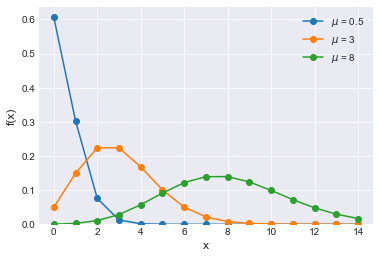

In [5]:
plt.style.use('seaborn-darkgrid')
x = np.arange(0, 15)
for m in [0.5, 3, 8]:
    pmf = st.poisson.pmf(x, m)
    plt.plot(x, pmf, '-o', label='$\mu$ = {}'.format(m))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0)
plt.legend(loc=1)
plt.show()

**PyMC3 usage**:

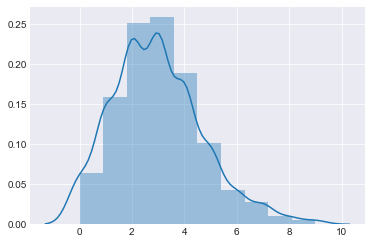

In [12]:
with pm.Model() as model:
    Poisson = pm.Poisson(mu = 3, name = "Poisson_var")

samples = Poisson.random(size=1000)  # Draw samples from the distribution
ax1 = sns.distplot(samples, bins=len(set(samples)))


** Usage as prior **: 
    
** Usage as likelihood **: 

This is due to the fact that the response data are **counts**. As a result, they tend to have characteristic properties. 

- discrete
- positive
- variance grows with mean

to account for this, we can do two things: (1) model the medal count on the **log scale** and (2) assume **Poisson errors**, rather than normal.

So, we will model the logarithm of the expected value as a linear function of our predictors:

$$\log(\lambda) = X\beta$$

In this context, the log function is called a **link function**. This transformation implies the mean of the Poisson is:

$$\lambda = \exp(X\beta)$$

We can plug this into the Poisson likelihood and use maximum likelihood to estimate the regression covariates $\beta$.

$$\log L = \sum_{i=1}^n -\exp(X_i\beta) + Y_i (X_i \beta)- \log(Y_i!)$$

As we have already done, we just need to code the kernel of this likelihood, and optimize!

## t-student distribution

Since there appear to be extreme ("outlier") values in the data, we will choose a Student-t distribution to describe the distributions of the scores in each group. This sampling distribution adds **robustness** to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. 

The three-parameter Student-t distribution allows for the specification of a mean $\mu$, a precision (inverse-variance) $\lambda$ and a degrees-of-freedom parameter $\nu$:

$$f(x|\mu,\lambda,\nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}} \left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
           
the degrees-of-freedom parameter essentially specifies the "normality" of the data, since larger values of $\nu$ make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

$$\begin{align}
y^{(drug)}_i &\sim T(\nu, \mu_1, \sigma_1) \\
y^{(placebo)}_i &\sim T(\nu, \mu_2, \sigma_2)
\end{align}$$

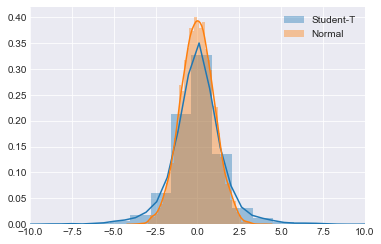

In [22]:
from pymc3 import StudentT, Normal
from pymc3 import StudentT

with pm.Model():
    StudentT_var = StudentT('drug_like', nu=2, mu=1, lam=3)
    
# Comparison T student and Normal
t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0, 1).random(size=10000)

sns.distplot(t, label='Student-T')
sns.distplot(n, label='Normal')
plt.legend()
plt.xlim(-10,10);


## Exponential

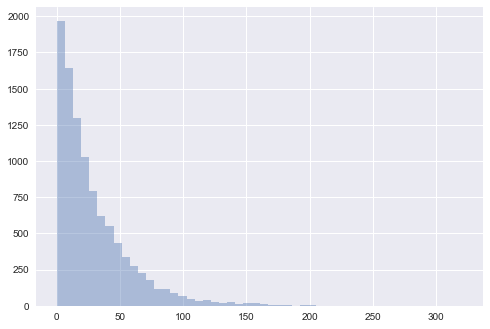

In [29]:
sns.distplot(Exponential.dist(1/29).random(size=10000), kde=False);

# Uniform


For the standard deviation, we know that the true value must be positive (no negative variances!). I will choose a uniform prior bounded from below at zero and from above at a value that is sure to be higher than any plausible value the true standard deviation (on the log scale) could take.

$$\sigma \sim U(0, 10)$$



In [ ]:
from pymc3 import Model, Uniform

with Model() as radon_model:
    
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)

## Beta 
A common choice in this context is the **beta distribution**, a continuous distribution with 2 parameters and whose support is on the unit interval:

$$ f(x \mid \alpha, \beta) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}$$

- Support: $x \in (0, 1)$
- Mean: $\dfrac{\alpha}{\alpha + \beta}$
- Variance: $\dfrac{\alpha \beta}{(\alpha+\beta)^2(\alpha+\beta+1)}$

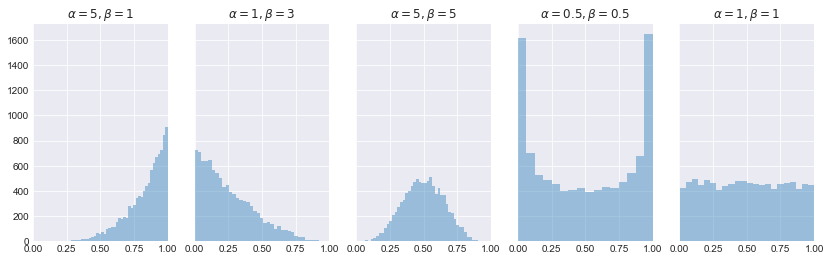

In [24]:
from pymc3 import Beta

params = (5, 1), (1, 3), (5, 5), (0.5, 0.5), (1, 1)

fig, axes = plt.subplots(1, len(params), figsize=(14, 4), sharey=True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Beta.dist(alpha, beta).random(size=10000), ax=ax, kde=False)
    ax.set_xlim(0, 1)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha, beta));

In [ ]:
Bernulli

$$\sigma \sim \text{HalfCauchy}(1)$$

The **half-Cauchy** distribution used here provides support over positive continuous values, and has relatively large tail probabilities, allowing for the possibility of extreme values.

## Gamma

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

1. The data are skewed, with a longer tail to the right than to the left
2. The data are positive-valued, since they are measuring rainfall
3. The data are continuous

There are a few possible choices, but one suitable alternative is the **gamma distribution**:

<div style="font-size: 150%;">  
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

![gamma](http://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/500px-Gamma_distribution_pdf.svg.png)

In [26]:
from scipy.stats.distributions import gamma

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))

NameError: name 'precip' is not defined

## Exponential

Truncated distribution

Suppose that we observe $Y$ truncated below at $a$ (where $a$ is known). If $X$ is the distribution of our observation, then:

$$ P(X \le x) = P(Y \le x|Y \gt a) = \frac{P(a \lt Y \le x)}{P(Y \gt a)}$$

(so, $Y$ is the original variable and $X$ is the truncated variable) 

Then X has the density:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

Suppose $Y \sim N(\mu, \sigma^2)$ and $x_1,\ldots,x_n$ are independent observations of $X$. We can use maximum likelihood to find $\mu$ and $\sigma$. 

First, we can simulate a truncated distribution using a `while` statement to eliminate samples that are outside the support of the truncated distribution.

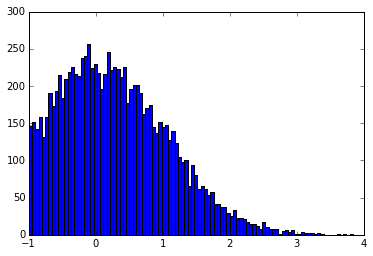

In [26]:
x = np.random.normal(size=10000)
a = -1
x_small = x < a
while x_small.sum():
    x[x_small] = np.random.normal(size=x_small.sum())
    x_small = x < a
    
_ = plt.hist(x, bins=100)

We can construct a log likelihood for this function using the conditional form:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

In [27]:
from scipy.stats.distributions import norm

trunc_norm = lambda theta, a, x: -(np.log(norm.pdf(x, theta[0], theta[1])) - 
                                      np.log(1 - norm.cdf(a, theta[0], theta[1]))).sum()

For this example, we will use another optimization algorithm, the **Nelder-Mead simplex algorithm**. It has a couple of advantages: 

- it does not require derivatives
- it can optimize (minimize) a vector of parameters

SciPy implements this algorithm in its `fmin` function:

In [28]:
from scipy.optimize import fmin

fmin(trunc_norm, np.array([1,2]), args=(-1, x))

Optimization terminated successfully.
         Current function value: 11077.807912
         Iterations: 44
         Function evaluations: 82


array([ 0.02244612,  0.99710875])